# Can we classify open clusters and globular clusters using their B-V index and true diameter?

### Nguyen Dac Hung, Kennedy Gurski, Matthew Land, Guilherme Eckert Roda, Vaibhav Chhajed
### 18 November 2024

**NOTE**: Original version of this notebook was corrupted while merging. It's name was changed to `old_corrupt_cluster_classify.ipynb`. If doing grading, please view the history of that notebook to check our progress.

## Abstract

"A star cluster is a group of stars that is gravitationally bounded together. They can be classified into two groups, globular and open clusters. Globular clusters are made of thousands to millions of predominantly older stars held together by strong self-gravitation. Open clusters, on the other hand, are made of younger stars loosely bounded together. Because of this difference in age of stars, globular clusters tend to be more red, corresponding to a higher B-V index (the difference in magnitude of light on the blue spectrum and visible spectrum) (Archinal & Hynes, 2003). Additionally, because of the difference in gravitation, we propose that globular clusters tend to be greater in size than open clusters. Here, we created three machine learning models, a linear regression model, a logistic regression model, and a SVM classification model to see if it is viable to classify clusters with these features. Out of our three models, the SVM classification model worked the best with a 100% accuracy rate, followed by the logistic regression and linear regression models with 80.7% and 69.5% accuracy respectively. These models can be applied in future catalogs to automate the classification process. This work also provides us with a model to better understand the main differences between globular and open clusters. We showed a higher the diameter corresponds to a lower the B-V index. "

## Team Roles
* **Nguyen Dac Hung:** Wrote the data reading code and conducted data analysis on three models and wrote abstract
* **Kennedy Gurski**: Provided background information and future implication of research for slides and notebook
* **Matthew Land:** Trained the Logistic Regression Model and made slides for the model
* **Guilherme Eckert Roda:** Trained the Linear Regression Model, made slides for the model, wrote notebook introduction, and made the slides look nice.
* **Vaibhav Chhajed:** Trained the SVM Classification Model and made slides for the model (he wrote the code on a separate notebook and sent it to Hung so he could upload the changes onto GitHub as he was experiencing problems with his machine at the time)

## Introduction

With our knowledge based on Michigan State University Astronomy, Physics, and Astrophysics classes and laboratories, besides some deep research and studying, our group, *Science 6*, came up with the scientific question: 

*can we identify Open vs Globular clusters using their B-V index and true diameter?*

To answer this question, we have explored cosmic datasets and multiple machine-learning techniques, such as regressions and support vector machines (SVM). A detailed step-by-step is presented in this notebook, but a summary can be found on the slide presented in-class. A copy of the slide presentation **Know the universe: classifying star systems** was made available below:

`https://docs.google.com/presentation/d/1Rl7JA3zQVYGm-howXNpeOa-yp72AMH0gdYElOipA7bg/edit?usp=sharing`

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler




## Functions

We define two functions to calculate the angular size/ angular diameter of an object from its half-light radius. This equation was obtained from King (1966) and gives the angular diameter of the celestial object in arcmin.

The second function calculates the true diameter of the object, in parsecs, from its angular size and distance from the Sun. This calculation is considered basic knowledge in astronomy so no source is given.

In [2]:
## Functions to calculate diameter of clusters
def get_angular_size(r_h):
	'''Go  from half light radius to true radius, based on King (1966) model for half light radius.
	Takes half light radius, in arcmin, and multiply by 2.5 to get angular radius.
	Multiply by 2 again to get angular diameter (angular size)
	'''
	return 2.5 * r_h * 2


def get_true_diameter(angular_size, dist):
	'''Takes angular size, in arcmin, and distance from Sun, in pc,
	Calculates true diameter (in pc)
	'''
	diam_rad = angular_size * (2.9089 * 10**-4) # 2.9089 * 10^-4 rad = 1 arcmin
	return diam_rad * dist 

## Data Reading

Here, we present code to read data from the two files:
* `glob_data.txt`
* `open_data.txt`

Since these files were not like regular csv files, were tab separated, and had descriptions of columns inside, we had to approach reading them in a special way.

In [3]:
# GLOBULAR CLUSTER DATA READING
glob_data1 = pd.read_csv("glob_data.txt", skiprows = 72, nrows = 157, sep='\s+', header = None)
glob_data2 = pd.read_csv("glob_data.txt", skiprows = 252, nrows = 157, sep='\s+', header = None)
glob_data3 = pd.read_csv("glob_data.txt", skiprows = 433, nrows = 157, sep='\s+', header = None)

# Combining the first two columns because the names were split
glob_data1["Cname"] = glob_data1.iloc[:,0] + glob_data1.iloc[:,1].astype(str)


glob_data = pd.concat([glob_data1["Cname"], glob_data1.iloc[:,4:10], glob_data1.iloc[:,10], glob_data2.iloc[:,4], glob_data3.iloc[:,9]], axis = 1)
glob_data.columns = ["Cname", "RA1", "RA2","RA3", "Dec1", "Dec2", "Dec3", "R_sun", "E(B-V)","r_h" ]
glob_data = glob_data.dropna()

# OPEN CLUSTER DATA READING
open_data = pd.read_csv("open_data.tsv", skiprows = 39, delimiter = "\t", header = None)

# Code generated by ChatGPT-4o (OpenAI, 2024) - November 2024 version, Prompt: "I have too many whitespace missing values in my dataset, how do I remove them?"
open_data = open_data.map(lambda x: x.strip() if isinstance(x, str) else x)  # Remove leading/trailing spaces
open_data.replace('', pd.NA, inplace=True)  # Replace empty strings with NaN
open_data = open_data.dropna()

open_data.columns = ["RA", "Dec", "Diam", "Dist", "Age (log years)", "Metallicity", "E(B-V)", "Cname", "_RA.icrs", "_DE.icrs"]

print("Globular Data","\n")
print(glob_data)

print("Open Data", "\n")
print(open_data)

Globular Data 

       Cname    RA1  RA2   RA3  Dec1    Dec2   Dec3  R_sun  E(B-V)   r_h
0     NGC104   5.67  -72   4.0  52.6  305.89 -44.89    4.5    0.04  3.17
1     NGC288  45.24  -26  34.0  57.4  152.30 -89.38    8.9    0.03  2.23
2     NGC362  14.26  -70  50.0  55.6  301.53 -46.25    8.6    0.05  0.82
4    NGC1261  16.21  -55  12.0  58.4  270.54 -52.12   16.3    0.01  2.99
5       Pal1  20.04   79  34.0  51.8  130.06  19.03   11.1    0.15  3.51
..       ...    ...  ...   ...   ...     ...    ...    ...     ...   ...
152  NGC7089  27.02    0  49.0  23.7   53.37 -35.77   11.5    0.06  1.06
153  NGC7099  22.12  -23  10.0  47.5   27.18 -46.84    8.1    0.03  1.03
154    Pal12  38.84  -21  15.0   9.4   30.51 -47.68   19.0    0.02  3.64
155    Pal13  44.44   12  46.0  19.2   87.10 -42.70   26.0    0.05  0.36
156  NGC7492  26.63  -15  36.0  41.4   53.39 -63.48   26.3    0.00  1.15

[137 rows x 10 columns]
Open Data 

          RA     Dec  Diam  Dist Age (log years) Metallicity E(B-V)  \


## Calculate the True Diameter (in parsecs)

Here, we calculate the true diameter of each cluster using the functions provided above.

In [4]:
# Converting the data in the dataframes from objects to floats
open_data['Diam'] = pd.to_numeric(open_data['Diam'], errors = "coerce")
open_data['Dist'] = pd.to_numeric(open_data['Dist'], errors = "coerce")

# Mask out negatives from glob_data
glob_data = glob_data.mask(glob_data['r_h'] < 0)

glob_data['true diam'] = get_true_diameter(get_angular_size(glob_data['r_h']), 1000 * glob_data['R_sun'])

# open_data true diameter
open_data['true diam'] = get_true_diameter(open_data['Diam'], open_data['Dist'])

## Checking correlations

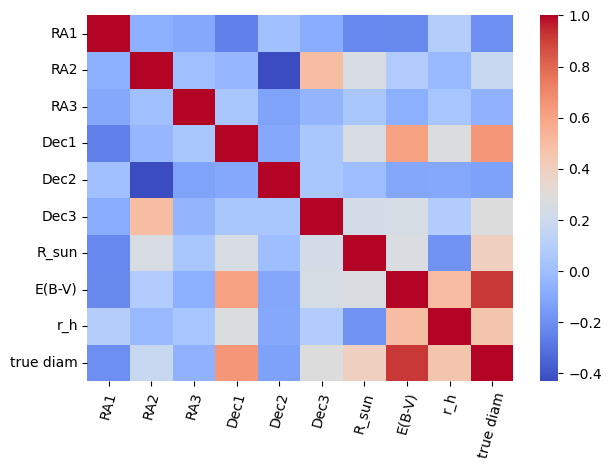

In [5]:
globular_correlation = (glob_data.drop("Cname", axis=1)).corr()

sns.heatmap(globular_correlation, cmap="coolwarm")
plt.xticks(rotation=75)
plt.tight_layout()

## Compiling all the data into one dataframe for training

In [6]:
# Add cluster_type column
glob_data['cluster_type'] = 1 #making globular clusters equal to one
open_data['cluster_type'] = 0 #making open clusters equal to zero

# Drop unwanted columns
glob_data_dropped = glob_data.drop(columns = ['Cname', 'RA1', 'RA2', 'RA3', 'Dec1', 'Dec2', 'Dec3', 'R_sun', 'r_h'])
open_data_dropped = open_data.drop(columns = ['RA', 'Dec', 'Diam', 'Dist', 'Age (log years)', 'Metallicity', 'Cname', '_RA.icrs', '_DE.icrs'])

# Rename diameter columns 
glob_data_dropped.rename(columns = {'true diam': 'diameter (pc)'}, inplace = True)
open_data_dropped.rename(columns = {'true diam': 'diameter (pc)'}, inplace = True)

# Combine datasets
clusters_df = pd.concat([glob_data_dropped, open_data_dropped])

# Drop extreme values
clusters_df = clusters_df.mask((clusters_df['diameter (pc)'] > 1000))

# Drops Nans
clusters_df = clusters_df.dropna()

# Make sure there are no objects
clusters_df = clusters_df.apply(pd.to_numeric, errors = 'raise')

# One Variable Linear Regression

We first train a linear regression model with the data we have just reduced. This model was trained by Guilherme Eckert Roda.

In [7]:
df = pd.concat([glob_data, open_data])
# clusters_df
model = sm.OLS(clusters_df["diameter (pc)"], sm.add_constant(clusters_df['E(B-V)']))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          diameter (pc)   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     17.05
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           5.24e-05
Time:                        21:12:29   Log-Likelihood:                -1017.2
No. Observations:                 213   AIC:                             2038.
Df Residuals:                     211   BIC:                             2045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5788      2.439      8.437      0.0

## Visualizing the data

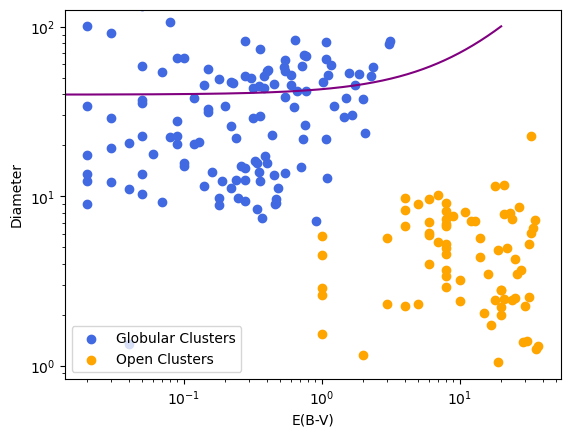

In [8]:
x = np.linspace(0,20, 1000)
y = 3.0443 * x + 39.7903
plt.scatter(glob_data["E(B-V)"], glob_data["true diam"], c="RoyalBlue", label="Globular Clusters")
plt.scatter(open_data["E(B-V)"], open_data["true diam"], c="orange", label="Open Clusters")
plt.plot(x,y, c="purple")
plt.xlabel("E(B-V)")
plt.ylabel("Diameter")
plt.yscale("log")
plt.xscale("log")
plt.legend()

In [9]:
results.params

const     20.578816
E(B-V)    15.906523
dtype: float64

# Analysis of the Linear Regression Model

After training the model, we compare how it performs against the real labels. We use the following assignment:
* `1.0` refers to a globular cluster
* `0.0` refers to an open cluster

In [10]:
# Mask to set the predictions made by the ML model (any points above the line are 1.0 and thus considered globular, any points below are 0 and considered open)
clusters_df['linear predictions'] =  0

condition = (clusters_df['E(B-V)'] * results.params[1] + results.params[0]) < clusters_df['diameter (pc)']
clusters_df.loc[condition, 'linear predictions'] = 1

print(clusters_df)

     E(B-V)  diameter (pc)  cluster_type  linear predictions
0      0.04      20.747729           1.0                   0
1      0.03      28.866469           1.0                   1
2      0.05      10.256781           1.0                   0
4      0.01      70.885530           1.0                   1
5      0.15      56.666826           1.0                   1
..      ...            ...           ...                 ...
909    0.24       7.214072           0.0                   0
940    0.27       9.773904           0.0                   0
948    0.18       1.250827           0.0                   0
961    0.96       1.309005           0.0                   0
998    0.27       8.290365           0.0                   0

[213 rows x 4 columns]


/tmp/ipykernel_273935/3693647371.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  condition = (clusters_df['E(B-V)'] * results.params[1] + results.params[0]) < clusters_df['diameter (pc)']


Now, we plot the confusion matrix.

[[79  0]
 [64 70]]


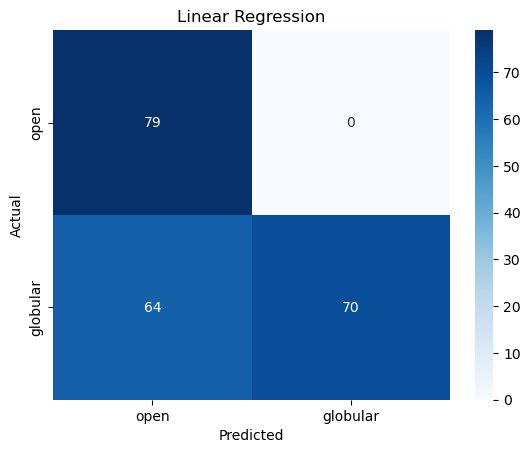

              precision    recall  f1-score   support

        open       0.55      1.00      0.71        79
    globular       1.00      0.52      0.69       134

    accuracy                           0.70       213
   macro avg       0.78      0.76      0.70       213
weighted avg       0.83      0.70      0.70       213

Accuracy: 0.6995305164319249


In [11]:
# Print confusion matrix with labels for each class
class_labels = ['open','globular']
print(confusion_matrix(clusters_df['cluster_type'], clusters_df['linear predictions']))

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(clusters_df['cluster_type'], clusters_df['linear predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Linear Regression")
plt.show()

# Print classification report
print(classification_report(clusters_df['cluster_type'], clusters_df['linear predictions'], target_names = class_labels))
accuracy = accuracy_score(clusters_df['cluster_type'], clusters_df['linear predictions'])
print(f'Accuracy: {accuracy}')

As observed, this model performed very poorly. As we can see from the scatter plot with the x and y axes scaled to log, it is impossible to linearly separate this data. However, using a logistic regression model might fit better. 

From the confusion matrix, it seems the model has trouble identifying globular clusters but was able to detect 100% of the open cluster. Overall, it seems that linear regression is not the best approach to this type of data. We should turn to the two other methods and see how they compare. 

# Logistic Regression Model

From the scatter plot in the linear regression section, it can be seen that a logistic model may perform better. This model was trained by Matthew Land.

In [12]:
# Creating features and labels to train model
clust = clusters_df
features = clust.iloc[:,0:2]
label = clust['cluster_type']

# Defining model
train_vectors, test_vectors, train_labels, test_labels = train_test_split(features, label, test_size = 0.25, train_size = 0.75, random_state = 0)

# Training model
logit_model = sm.Logit(train_labels, sm.add_constant(train_vectors))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.172415
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           cluster_type   No. Observations:                  159
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            2
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.7326
Time:                        21:12:29   Log-Likelihood:                -27.414
converged:                       True   LL-Null:                       -102.54
Covariance Type:            nonrobust   LLR p-value:                 2.371e-33
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.2803      1.594     -4.569      0.000     -10.404      -4.157
E(B-V)            4

### Prediction and Accuracy

In [13]:
# Predict data
prediction = result.predict(sm.add_constant(test_vectors))

# Finalize the predictions (if > 0.5 classify as 1, if <0.5, classify as 0), code generated by ChatGPT-4o - November 2024 ver. (OpenAI, 2024)
# Prompt: {I have an array of numbers from 0 to 1.0, how do I make it so that numbers less than 0.5 become 0 and numbers greater become 1}
prediction_labels = (prediction > 0.5).astype(float)

comparison = pd.concat([prediction_labels, test_labels], axis = 1)
comparison.columns = ["Prediction", "Actual"]

# Accuracy of prediction
print(comparison)
accuracy = accuracy_score(test_labels, prediction_labels)
print(f'Accuracy: {accuracy}')
print(classification_report(test_labels, prediction_labels))


     Prediction  Actual
710         0.0     0.0
46          0.0     1.0
105         0.0     1.0
346         0.0     0.0
184         1.0     0.0
89          0.0     1.0
115         1.0     1.0
60          0.0     0.0
6           0.0     1.0
97          1.0     1.0
67          1.0     1.0
120         0.0     0.0
277         0.0     0.0
134         1.0     1.0
88          1.0     1.0
803         0.0     0.0
149         1.0     1.0
17          0.0     1.0
208         0.0     0.0
251         0.0     0.0
467         0.0     0.0
739         0.0     0.0
712         0.0     0.0
590         0.0     0.0
111         0.0     0.0
24          1.0     1.0
410         0.0     0.0
21          1.0     1.0
100         1.0     1.0
85          1.0     1.0
9           0.0     1.0
75          1.0     1.0
104         0.0     0.0
116         1.0     1.0
42          0.0     0.0
296         0.0     0.0
40          1.0     1.0
210         0.0     0.0
106         1.0     1.0
632         0.0     0.0
127         1.0 

### Plotting the data in 3D

We plotted the data in 3D to see whether adding an extra dimension could tell us more about its separability. 

/tmp/ipykernel_273935/785398750.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = result.params[0]
/tmp/ipykernel_273935/785398750.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_grid = intercept + coef[0] * x1_grid + coef[1] * x2_grid #Helped with ChatGPT-4, Prompt: "How to plot logistic regression plane in 3D". Accessed 11/17/2024.


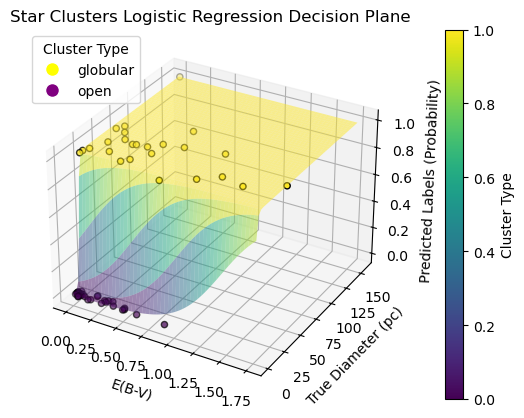

In [14]:
# Extracting the intercept and coefficients
intercept = result.params[0]
coef = result.params[1:]

# Creating grid for surface
x1_range = np.linspace(test_vectors['E(B-V)'].min(), test_vectors['E(B-V)'].max(), 50)  # Range for X1 (E(B-V))
x2_range = np.linspace(test_vectors['diameter (pc)'].min(), test_vectors['diameter (pc)'].max(), 50)  # Range for X2 (diameter)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Compute log-odds for each point on the grid
z_grid = intercept + coef[0] * x1_grid + coef[1] * x2_grid #Helped with ChatGPT-4, Prompt: "How to plot logistic regression plane in 3D". Accessed 11/17/2024.

# Find probabilities
probabilities = 1 / (1 + np.exp(-z_grid))

# Plot regression points and surface
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
scatter = ax.scatter3D(test_vectors['E(B-V)'], test_vectors['diameter (pc)'], prediction_labels, c = prediction_labels, cmap='viridis', edgecolor = 'k')
ax.plot_surface(x1_grid, x2_grid, probabilities, alpha=0.5, cmap='viridis')

# Title and labels
plt.title('Star Clusters Logistic Regression Decision Plane')
ax.set_xlabel('E(B-V)')
ax.set_ylabel('True Diameter (pc)')
ax.set_zlabel('Predicted Labels (Probability)')
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster Type')

# Add legend, code generated by ChatGPT-4o, November 2024 ver. (OpenAI, 2024)
color_map = {'globular': 'yellow', 'open': 'purple'}
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cluster_type)
    for cluster_type, color in color_map.items()
]
ax.legend(handles=handles, title="Cluster Type")
plt.show()

# Analysis of the Logistic Regression Model

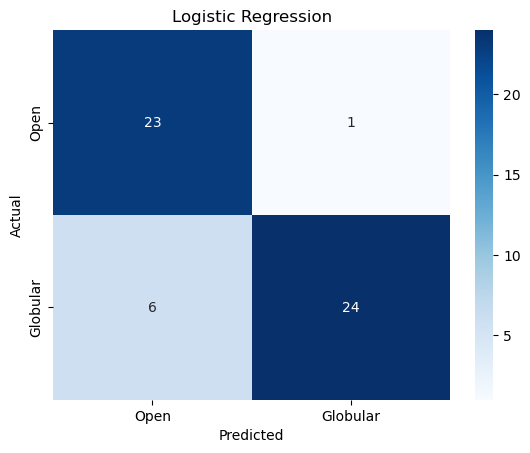

In [15]:
class_labels = ['Open', 'Globular']

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(test_labels, prediction_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression")
plt.show()


With an accuracy rate of roughly 0.87, the Logistic Regression model performed fairly well. The model was trained with a test sample and train sample of 25% and 75% respectively. As observed from the confusion matrix, it has a false open rate of roughly 0.207 and a false globular rate of roughly 0.04, the model seems to have more difficulty identifying open clusters as opposed to to globular clusters. This is perhaps understandable as the `open_cluster` dataset had more NaN values that we had to get rid of, resulting in fewer data points. The model might not have had enough data to be trained on. This model could be more refined if out dataset was larger. 

# The Support Vector Machine (SVM) Classification Model

The previous model proved to be more effective than the linear model. However, perhaps a classification model could perform better. We train a ML model using SVM classification similar to in class. In this model, we handle missing data by replacing them with NaN values and split the test and training data by 30%, 70% respectively. This model was trained by Vaibhav Chhajed. 

Best C: 10.0
Best gamma: 0.01
Predicting names on the test set
[[39  0]
 [ 0 26]]


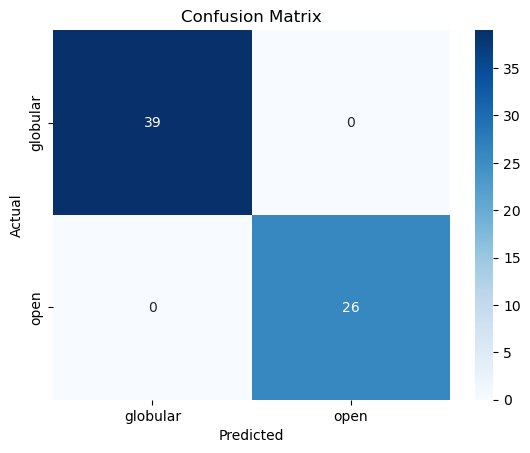

              precision    recall  f1-score   support

    globular       1.00      1.00      1.00        39
        open       1.00      1.00      1.00        26

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



In [16]:
# Add 'ClusterType' column for each dataset
glob_data['ClusterType'] = 'globular'
open_data['ClusterType'] = 'open'

# Select relevant features and create copies to avoid warnings
glob_data_features = glob_data[['true diam', 'R_sun', 'E(B-V)', 'r_h']].copy()
open_data_features = open_data[['Diam', 'Dist', 'E(B-V)']].copy()

glob_data_features['ClusterType'] = glob_data['ClusterType']
open_data_features['ClusterType'] = open_data['ClusterType']

# Combine datasets and shuffle to add randomness
combined_data = pd.concat([glob_data_features, open_data_features], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

# Impute missing values in combined_data for each column
imputer = SimpleImputer(strategy='median')
combined_data[['true diam', 'R_sun', 'E(B-V)', 'r_h']] = imputer.fit_transform(
    combined_data[['true diam', 'R_sun', 'E(B-V)', 'r_h']]
)

# Check for any remaining NaN values and handle if needed
if combined_data.isna().sum().sum() > 0:
    combined_data = combined_data.fillna(0)  # Replace remaining NaNs with zero if any are left

# Separate features and target
X = combined_data.drop('ClusterType', axis=1)
y = combined_data['ClusterType']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define parameter grid for C and gamma
param_grid = {
    'C': np.logspace(-2, 2, 5),      # C values from 0.01 to 100
    'gamma': np.logspace(-3, 1, 5)   # gamma values from 0.001 to 10
}

# Use GridSearchCV to find the best parameters
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print(f"Best C: {best_C}")
print(f"Best gamma: {best_gamma}")
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assume the model has been trained and `X_test`, `y_test`, and `grid_search` exist

# Predict the labels for the test set
print("Predicting names on the test set")
pred_labels = grid_search.predict(X_test)  # Ensure grid_search is defined and trained

# Get the unique class labels from y_test to use as the 'labels' argument
class_labels = np.unique(y_test)  # Ensure y_test is defined and contains actual class labels

# Print confusion matrix with labels for each class
print(confusion_matrix(y_test, pred_labels, labels=class_labels))

# Visualize confusion matrix as a heatmap
cm = confusion_matrix(y_test, pred_labels, labels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_test, pred_labels))

This model proved to be the most successful out of all with an accuracy of 100%. It produced 0 false predictions. We should, however, still be suspicious because it seems unlikely that this model could have exactly an 100% accuracy rate. In the future, with more data, and thus a larger training and testing set, we could better refine this model alongside the logistic regression model.

# Analysis of the SVM Classification Model

We conducted regression and classification of three different models to see whether a machine learning algorithm could be used to identify open star clusters vs globular star clusters. The two primary features we used were the B-V index and the true diameter of the cluster.

The most successful model seemed to be the SVM classification model as it achieved a 100% accuracy rate with 0 false positives and 0 false negatives.

# Conclusion and Discussion

We conducted regression and classification of three different models to see whether a machine learning algorithm could be used to identify open star clusters vs globular star clusters. The two primary features we used were the B-V index and the true diameter of the cluster.

The most successful model seemed to be the SVM classification model as it achieved a 100% accuracy rate with 0 false positives and 0 false negatives.

### Plot the weighted average precision bar graph

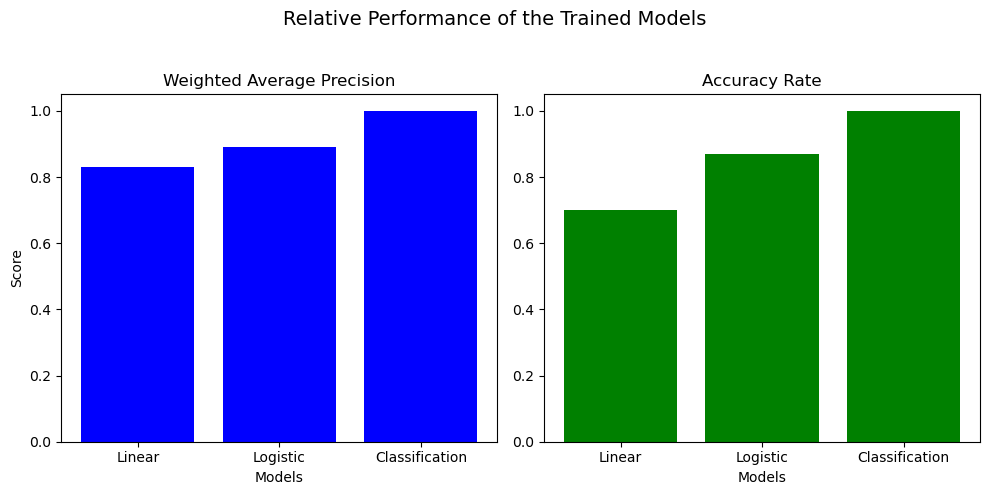

In [17]:
# Data
weighted_average_precision = [0.83, 0.89, 1.0] # weighted average precision was retrieved from numbers given above
accuracy_rate = [0.70, 0.87, 1.0] # accuracy was retrieved from numbers given above
models = ['Linear', 'Logistic', 'Classification']

# Plot weighted average precision
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(models, weighted_average_precision, color='blue')
axes[0].set_title('Weighted Average Precision')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score')

# Plot accuracy rate
axes[1].bar(models, accuracy_rate, color='green')
axes[1].set_title('Accuracy Rate')
axes[1].set_xlabel('Models')

# Overall title
fig.suptitle("Relative Performance of the Trained Models", fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

While the linear model seemed to perform bad at a first glance, the plots tell us it achieved a precision of 0.8 and an accuracy of roughly 0.7. The model performed better than thought. However, since the data is not linearly separable, as observed from the scatter plot above, it is still not ideal. 

### What does this all imply?
Our models imply that there is a correlation between Globular and Open Clusters regarding true diameter and B-V Index:
* High B-V = Low Diameter, Low B-V = High Diameter

From this we can conclude that it is indeed possible to classify star clusters using their B-V index and true diameter. Because globular clusters are more gravitationally bound and made of older stars than open clusters, they are tend to be smaller and more red (higher B-V) index than  open clusters. Even though overlaps may exist, our models may be able to resolve them. Future research should look into implementing machine learning in classifying star clusters to automate the process. 

# Limitations and Future Implications

Because the data was written in a special way, our data reading methods were very crude, and we were unable to verify that all these values have been read correctly. The results of the AI training may have been affected by this. 

The globular cluster dataset also only contained clusters from the Milky Way, so the dataset might not be representative of all globular clusters in the universe. Open cluster data was also only from clusters in the visible spectrum. Thus, it might be that some open clusters are not visible in this wavelength range due to the interstellar and intergalactic medium. As we look deeper into space, the composition of objects changes drastically and their sizes vary greatly as well. Future efforts to refine these models should search for data that is better representative of all clusters.

Additionally, future research could also try different parameters to see if they are better correlated. For example, they could use find whether metallicity or distance from the Earth can be used as classifiers. 

# References
Archinal, B. A., & Hynes, S. J. (2003). Star Clusters. In Google Books. Willman-Bell. https://books.google.com/books?id=2WJ3AAAACAAJ

Bennett, J. O., M Donahue, Schneider, N., & Voit, M. (2020). The Cosmic Perspective (9th ed.). Pearson Education, Inc.

Dias, W. S., Alessi, B. S., Moitinho, A., & Lepine, J. R. D. (2014). VizieR Online Data Catalog: Optically visible open clusters and Candidates (Dias+ 2002-2015). VizieR Online Data Catalog, 1, B-ocl.

Harris, W. E. (2010, December 15). A New Catalog of Globular Clusters in the Milky Way. ArXiv.org. https://arxiv.org/abs/1012.3224v1